In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.cluster import KMeans


In [12]:
df=pd.DataFrame(pd.read_csv(r"C:\Users\USER\Downloads\consumerData.csv"))
today=pd.to_datetime("2025-07-23")
df["OrderDate"]=pd.to_datetime(df["OrderDate"])
recent=df.groupby("CustomerID")["OrderDate"].max().reset_index()
recent["Recent"]=(today-(recent["OrderDate"])).dt.days

frequency=df.groupby("CustomerID")["OrderID"].count().reset_index(name="frequency")
purchase=df.groupby("CustomerID")["OrderAmount"].sum().reset_index(name="totalamount")
rfm=recent.merge(frequency, on="CustomerID").merge(purchase, on="CustomerID")

for i in ['OrderStatus', 'PaymentMethod', 'City', 'State']:
    df[i] = df[i].fillna(df[i].mode()[0])
cat=df[["CustomerID","OrderStatus","PaymentMethod","City","State"]]
cat=cat.merge(recent[["CustomerID","OrderDate"]],on="CustomerID").sort_values(by="OrderDate",ascending=False).drop_duplicates(subset=["CustomerID"],keep="first").drop("OrderDate",axis=1)


le_dict = {}
for i in ["OrderStatus","PaymentMethod","City","State"]:
   le = LabelEncoder()
   cat[i] = le.fit_transform(cat[i])
   le_dict[i] = le  # save encoder for later
rfm=rfm.merge(cat,on="CustomerID")
features=['Recent', 'frequency', 'totalamount',
       'OrderStatus', 'PaymentMethod', 'City', 'State']
sc=StandardScaler()
scaled=pd.DataFrame(sc.fit_transform(rfm[features]),columns=features)
k=KMeans(n_clusters=5,random_state=42)
rfm["cluster"]=k.fit_predict(scaled,)

In [ ]:
# w=[]
# for i in range(1,28):
#   k=KMeans(n_clusters=i)
#   k.fit_predict(scaled)
#   w.append(k.inertia_)
 #this is an elbow method to check 

In [78]:
from sklearn.metrics.pairwise import euclidean_distances
feat=rfm[['Recent', 'frequency', 'totalamount',
       'OrderStatus', 'PaymentMethod', 'City', 'State', 'cluster']].copy()

In [86]:
def similarcust(custid,rfm):
    if custid not in rfm["CustomerID"].values:
        print(f"nothing is found")
        return
    index=rfm[rfm["CustomerID"]==custid].index[0]
    cluster=rfm.loc[index,"cluster"]
    similar_cluster=rfm[(rfm["cluster"]==cluster) & (rfm.index!=index)]
    distance=euclidean_distances([scaled.loc[index]],scaled.loc[similar_cluster.index])[0]
    top=similar_cluster.iloc[distance.argsort()[:5]]
    return top["CustomerID"]
   

In [74]:
rfm[rfm["CustomerID"]=="CUST0001"]

,CustomerID,OrderDate,Recent,frequency,totalamount,OrderStatus,PaymentMethod,City,State,cluster
0,CUST0001,2025-07-02,21,7,1903.28,2,4,8,0,0


In [87]:
i=input(print(f"enter the cust id"))
similarcust(i,rfm)

enter the cust id


None CUST0001


1655    CUST1661
549     CUST0553
970     CUST0976
875     CUST0880
1055    CUST1061
Name: CustomerID, dtype: object

In [139]:
cluster_sumamry=rfm.groupby("cluster")[["Recent","frequency","totalamount"]].mean().round(2).reset_index(

In [140]:
cluster_sumamry["count"]=rfm["cluster"].value_counts().sort_index()

In [101]:
cluster_index={

    1: "High Value / Loyal",
    0:  "Mid-Tier Loyal" ,
    2:"At Risk / Dormant",
    3:"Recent Regular", 
    4: "Potential Loyalist",
}
rfm["segment"]=rfm["cluster"].map(cluster_index)

In [142]:
cluster_sumamry

,cluster,Recent,frequency,totalamount,count
0,0,41.30,5.10,1262.21,509
1,1,31.95,9.31,2508.96,425
2,2,107.79,3.44,856.63,229
3,3,36.95,5.52,1339.03,394
4,4,38.24,5.70,1450.56,437


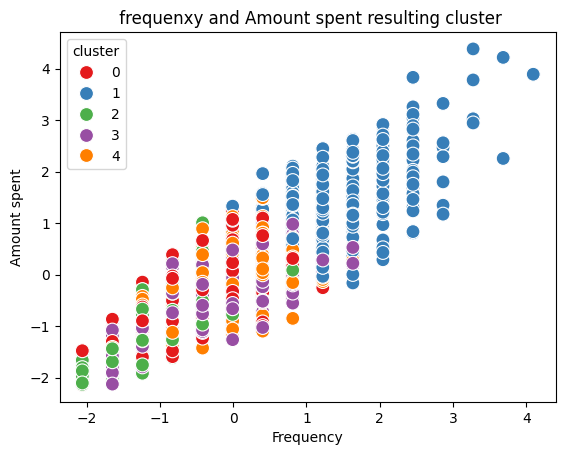

In [162]:
graph=scaled.copy()
graph["cluster"]=rfm["cluster"]

sn.scatterplot(x="frequency",y="totalamount",hue="cluster",data=graph,s=100,palette="Set1")
plt.xlabel("Frequency")
plt.ylabel("Amount spent")
plt.title(" frequenxy and Amount spent resulting cluster")
plt.show()

In [161]:
graph1=cluster_sumamry.copy()

Text(0, 0.5, 'standarized_amount')

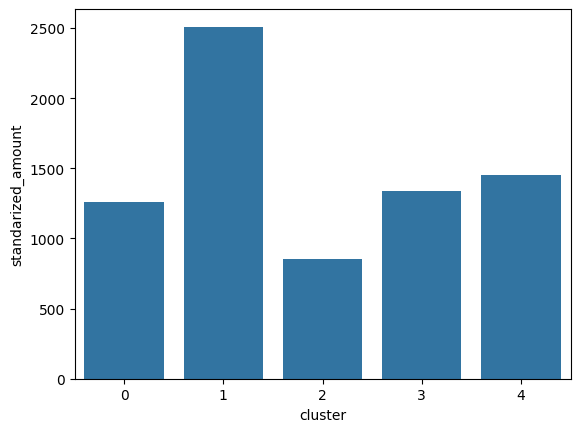

In [171]:
sn.barplot(x="cluster",y="totalamount",data=graph1)
plt.ylabel("standarized_amount")

In [179]:
fet=rfm[["Recent","frequency","totalamount","]]


<Axes: >

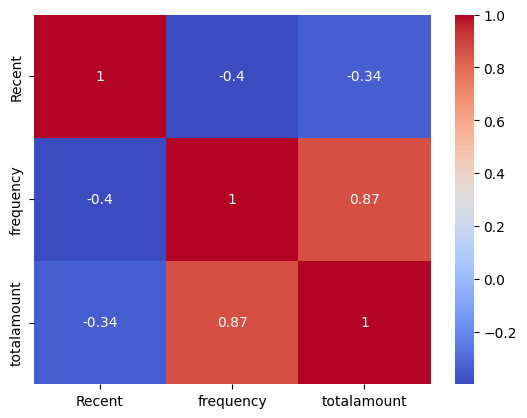

In [181]:
sns.heatmap(data=fet.corr(),annot=True,cmap="coolwarm")